# LUIS Scoring Evaluation
This notebook serves to evaluate your LUIS scoring report generated by [GLUE](https://github.com/microsoft/glue).

In [126]:
# Import required packages
import pandas as pd
import numpy as np
import json
from pandas import json_normalize
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scikitplot.metrics import plot_roc_curve
import seaborn as sns; sns.set(rc={'figure.figsize':(10,10)})
import matplotlib.pyplot as plt 

## Input Data
Below, you will import the scoring file generated by GLUE. 

In [127]:
# Import scoring file
df_scoring = pd.read_csv('../assets/examples/output_files/example_luis_scoring.csv', sep=",", encoding="utf-8")
df_scoring.head()

,intent,text,prediction_text,score_text,prediction_drop_text,luis_treshold
0,BookFlight,I would like to book a flight to Frankfurt.,BookFlight,0.898678,None,0.9
1,CancelFlight,I want to cancel my journey to Kuala Lumpur,CancelFlight,0.915191,CancelFlight,0.9
2,ChangeFlight,I would like to change my flight to Singapore.,ChangeFlight,0.916477,ChangeFlight,0.9
3,BookSeat,I would like to book a seat on my flight to St...,BookSeat,0.910444,BookSeat,0.9
4,CancelFlight,I want to cancel my journey to Kuala Lumpur,CancelFlight,0.915191,CancelFlight,0.9


In [128]:
# Set treshold of scoring file to a variable
treshold_default = df_scoring['luis_treshold'].loc[0]

In [129]:
# Set dummy variables for treshold steps
treshold_range = np.arange(0.0, 1.0, 0.05)
treshold_labels = [f'above_treshold_{str(treshold).replace(".", "")[:3]}' for treshold in treshold_range]
df_tresholds = df_scoring.copy()
for treshold in zip(treshold_range, treshold_labels):
    df_tresholds[treshold[1]] = df_tresholds.score_text.apply(lambda x: x >= treshold[0]).astype(int)

## Classification Reports

### Report for Predictions

              precision    recall  f1-score   support

  BookFlight       0.50      1.00      0.67         2
    BookSeat       1.00      0.60      0.75         5
CancelFlight       1.00      0.50      0.67         4
ChangeFlight       0.71      1.00      0.83         5

    accuracy                           0.75        16
   macro avg       0.80      0.78      0.73        16
weighted avg       0.85      0.75      0.74        16



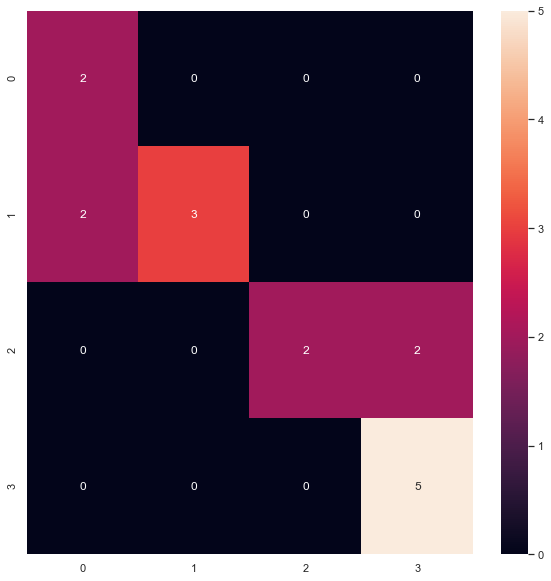

In [130]:
print(classification_report(df_scoring.intent, df_scoring.prediction_text))
sns.heatmap(confusion_matrix(df_scoring.intent, df_scoring.prediction_text), annot=True)

### Report for treshold-validated Predictions

              precision    recall  f1-score   support

  BookFlight       0.00      0.00      0.00         2
    BookSeat       1.00      0.60      0.75         5
CancelFlight       1.00      0.50      0.67         4
ChangeFlight       0.71      1.00      0.83         5
        None       0.00      0.00      0.00         0

    accuracy                           0.62        16
   macro avg       0.54      0.42      0.45        16
weighted avg       0.79      0.62      0.66        16



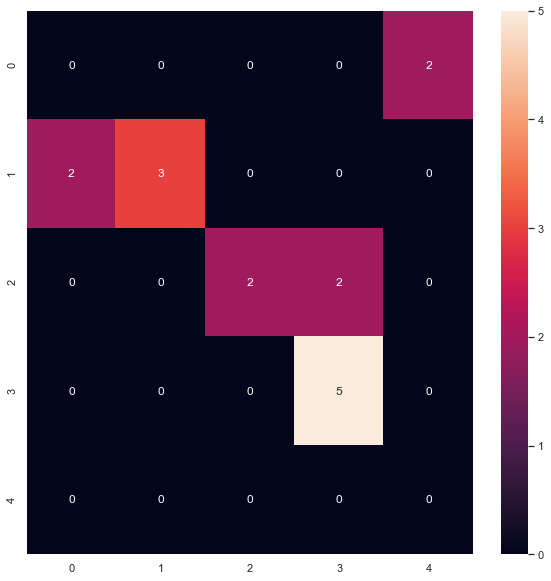

In [131]:
print(classification_report(df_scoring.intent, df_scoring['prediction_drop_text']))
sns.heatmap(confusion_matrix(df_scoring.intent, df_scoring['prediction_drop_text']), annot=True)

#### Wrong Classifications

In [132]:
# Create df only including wrong classifications
df_wrong_classifications = df_scoring[~(df_scoring.intent == df_scoring.prediction_text)]
display(df_wrong_classifications)

,intent,text,prediction_text,score_text,prediction_drop_text,luis_treshold
7,CancelFlight,I want to cancel my journey to Kuala Lumpur,ChangeFlight,0.915191,ChangeFlight,0.9
9,BookSeat,I would like to book a seat on my flight to St...,BookFlight,0.910444,BookFlight,0.9
12,CancelFlight,I want to cancel my journey to Kuala Lumpur,ChangeFlight,0.915191,ChangeFlight,0.9
14,BookSeat,I would like to book a seat on my flight to St...,BookFlight,0.910444,BookFlight,0.9


BookSeat        2
CancelFlight    2
Name: intent, dtype: int64


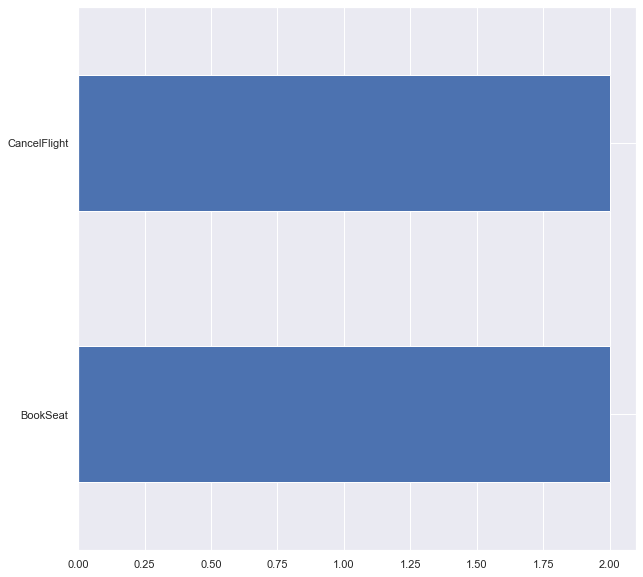

In [133]:
# Create bar plot of frequently misclassified values, if there are any
if len(df_wrong_classifications) > 0:
    print(df_scoring[~(df_scoring.intent == df_scoring.prediction_text)]['intent'].value_counts())
    df_scoring[~(df_scoring.intent == df_scoring.prediction_text)]['intent'].value_counts().sort_values().plot(kind = 'barh')
else:
    print("Nothing to display, as no wrong classifications!")

### Bad scores, but correctly classified

In [134]:
df_correct_bad_score = df_scoring.loc[(df_scoring.score_text < treshold_default) & (df_scoring.intent == df_scoring.prediction_text)]
display(df_correct_bad_score)

,intent,text,prediction_text,score_text,prediction_drop_text,luis_treshold
0,BookFlight,I would like to book a flight to Frankfurt.,BookFlight,0.898678,None,0.9
15,BookFlight,I would like to book a flight to Frankfurt.,BookFlight,0.898678,None,0.9


(0, 1)

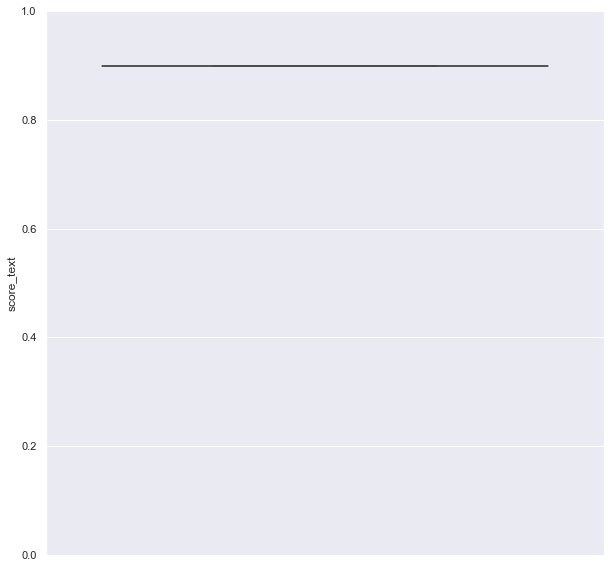

In [135]:
# Distribution of bad scores but correctly classified
am = sns.boxplot(y='score_text', data=df_correct_bad_score)
am.set_ylim([0, 1])

In [136]:
# Most frequent correct classifications even tho having bad confidence scores
df_scoring.loc[(df_scoring.score_text < treshold_default) & (df_scoring.intent == df_scoring.prediction_text)]['prediction_text'].value_counts()

BookFlight    2
Name: prediction_text, dtype: int64

### Good scores, but wrongly classified

In [137]:
print('Good scores, but wrongly classified')
display(df_scoring[(df_scoring.score_text > treshold_default) & (df_scoring.intent != df_scoring.prediction_text)].head())

Good scores, but wrongly classified


,intent,text,prediction_text,score_text,prediction_drop_text,luis_treshold
7,CancelFlight,I want to cancel my journey to Kuala Lumpur,ChangeFlight,0.915191,ChangeFlight,0.9
9,BookSeat,I would like to book a seat on my flight to St...,BookFlight,0.910444,BookFlight,0.9
12,CancelFlight,I want to cancel my journey to Kuala Lumpur,ChangeFlight,0.915191,ChangeFlight,0.9
14,BookSeat,I would like to book a seat on my flight to St...,BookFlight,0.910444,BookFlight,0.9


(0, 1)

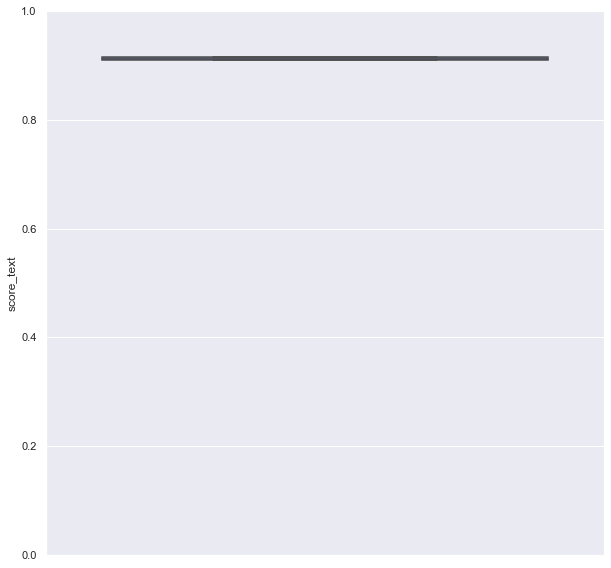

In [138]:
# Distribution of good scores but wrongly classified
ax = sns.boxplot(y='score_text', data=df_scoring[(df_scoring.score_text > treshold_default) & (df_scoring.intent != df_scoring.prediction_text)])
ax.set_ylim([0, 1])

## 